#### In this Project, Timeseries Data on Vaccinations is used.

techniques used:

- Survivale-analysis and Hazardfunctions
- Timeseries Analysis 

In [ ]:
import pandas as pd
import math
import csv
import numpy as np
import requests 
import lifelines 
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [ ]:
cov = pd.read_csv("Data/cov.csv")

Exploring all the possible varaibles from the Data.

In [ ]:
cov.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

Generate a time censored DataFrame for Germany only, with fewer Variables. 

In [ ]:
ger = cov[cov.iso_code == "DEU"]
ger_pop = int(ger.population.unique())

ger['date'] = pd.to_datetime(ger['date'])
start_date = '2020-02-25'
end_date = '2022-03-01'
mask = (ger['date'] >= start_date) & (ger['date'] <= end_date)
ger = ger.loc[mask]

#from 2020-02-25 to 2022-03-01

C:\Users\zogaj\AppData\Local\Temp\ipykernel_9532\3171030135.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ger['date'] = pd.to_datetime(ger['date'])


In [ ]:
ger = ger[["date","new_vaccinations", "total_vaccinations","people_fully_vaccinated","new_people_vaccinated_smoothed",'total_boosters',
           "new_deaths","total_deaths",'new_deaths_smoothed', 
           'total_cases', 'new_cases', 'new_cases_smoothed']]

idx = [i for i in range(1,len(ger)+1)]
ger["idx"] = idx
ger.head()

,date,new_vaccinations,total_vaccinations,people_fully_vaccinated,new_people_vaccinated_smoothed,total_boosters,new_deaths,total_deaths,new_deaths_smoothed,total_cases,new_cases,new_cases_smoothed,idx
97594,2020-02-25,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.143,32.0,1.0,0.714,1
97595,2020-02-26,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.143,35.0,3.0,1.000,2
97596,2020-02-27,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.143,43.0,8.0,2.000,3
97597,2020-02-28,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.000,67.0,24.0,5.143,4
97598,2020-02-29,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.000,112.0,45.0,11.571,5


First time-series glance, at the corona deaths and vaccinations in Germany. 

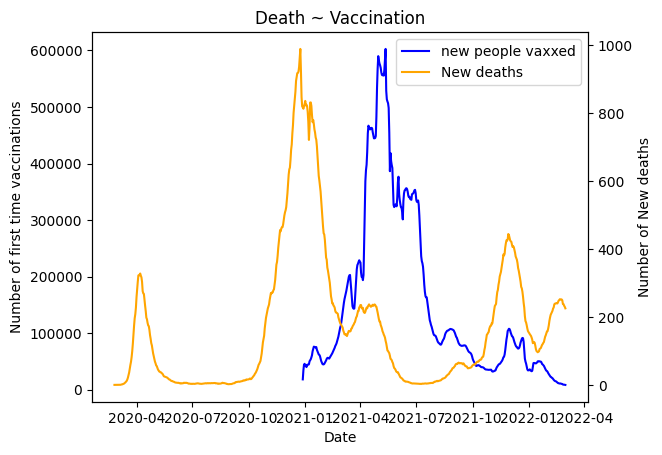

In [ ]:
fig, ax1 = plt.subplots()
lin1 = ax1.plot(ger.date, ger.new_people_vaccinated_smoothed, color = "blue", label = "new people vaxxed")

plt.ylabel("Number of first time vaccinations")
plt.xlabel("Date")
plt.title("Death ~ Vaccination")

ax2 = ax1.twinx() #creates the second axis 
lin2 = ax2.plot(ger.date, ger.new_deaths_smoothed, color = "orange", label = "New deaths")
ax2.set_ylabel("Number of New deaths")

lines = lin1 + lin2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels)
plt.show()

Create a columns of the Number of people who are not vaxed at all / fully vaccinated / fully boostered yet. 
<br>
Assuming a constant population (~83 Mio for Germany) over time. 

In [ ]:
ger["not_vaxed_at_all"] = ger_pop - np.cumsum(ger.new_people_vaccinated_smoothed)
ger["not_full_vaxed"] = ger_pop - ger.people_fully_vaccinated #allready cumulated
ger["not_boostered"] = ger_pop - ger.total_boosters #allready cumulated

ger["new_full_vaxed"] = ger.people_fully_vaccinated.diff().ewm(alpha=0.1).mean() #smoothed
ger["new_boostered"] = ger.total_boosters.diff().ewm(alpha=0.1).mean() #smoothed

s_t = ger.not_vaxed_at_all/ger_pop
s_t2 = ger.not_full_vaxed/ger_pop
s_t3 = ger.not_boostered/ger_pop

From this generated Data, we can use **Survivalanalysis**, to see how long it took for Citizens to take their first vaccine. This is a slightly unortodox approach, since we usually want flat survivalcurves with few cases of the occurence in medical Statistics. However it can give insigths about the Vaccination campaing in Germany (i.e. how fast a certain rate was achived). 

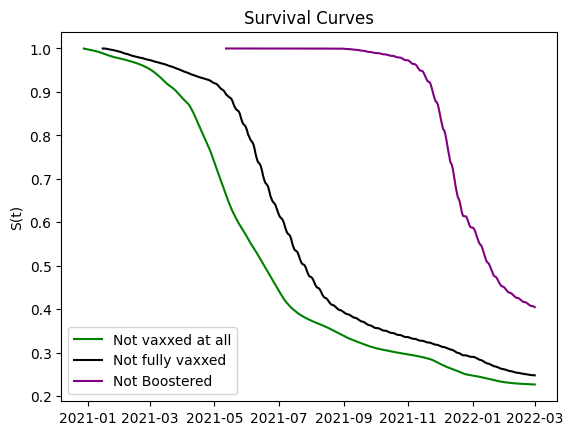

In [ ]:
plt.title("Survival Curves")
plt.ylabel("S(t)")

plt.plot(ger.date, s_t, color = "green", label = "Not vaxxed at all")
plt.plot(ger.date, s_t2, color = "black", label = "Not fully vaxxed")
plt.plot(ger.date, s_t3, color = "purple", label = "Not Boostered")
plt.legend()
plt.show()

Percentage of pouplation unvaccinated at given date. 

In [ ]:
#censor the index, which the first (type of) vaccination occured 
delta = ger[["idx", "new_people_vaccinated_smoothed"]].dropna().idx.iloc[0] #very first 
delta2 = ger[["idx", "people_fully_vaccinated"]].dropna().idx.iloc[0]  # first fully vaxxed
delta3 = ger[["idx", "total_boosters"]].dropna().idx.iloc[0] #first booster 
lastdate = max(ger.idx)

print("from: ",delta, " to ",lastdate,"\n",
       "from: ",delta2, " to ",lastdate,"\n",
       "from: ",delta3, " to ",lastdate,"\n")

from:  308  to  736 
 from:  326  to  736 
 from:  443  to  736 



In [ ]:
probs = ger.new_people_vaccinated_smoothed / ger_pop #sum(ger.new_people_vaccinated_smoothed.dropna()) 
days = (ger.idx - delta) 
days = days[days >= 0] + 1
probs = probs[probs >= 0]

pmf = dict(zip(days, probs))
#pmf = {key: value for key, value in pmf.items() if key >= 0}

def normalize(pmf):
    total = sum(pmf.values()) # sum of probs
    new_pmf = {day:(prob/total) for day, prob in pmf.items()}
    #assert 0.9999999 <= sum(new_pmf.values()) <= 1.0000001
    return new_pmf

#pmf = normalize(pmf)
probs = list(pmf.values())

The Hazard-function for **new Vaccinations** gives insides on what Day after the beginning of the Vaccination-campaign it is how likely to receive their first vaccination. 

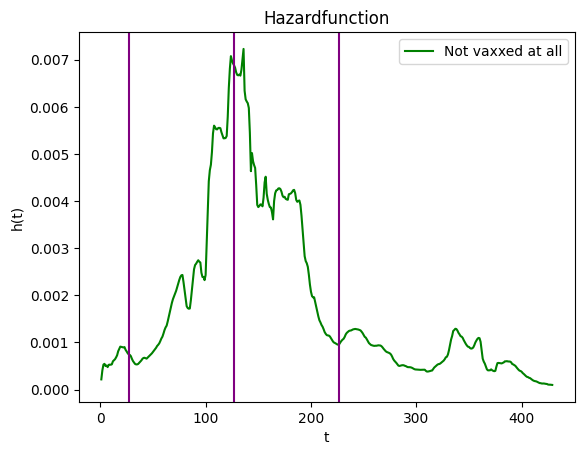

In [ ]:
plt.plot(days,probs, color = "green", label = "Not vaxxed at all")

gamma1 = sum((days * probs).dropna()) #mu
gamma2 = sum((days**2 * probs).dropna())
var = gamma2 - gamma1**2
sd = math.sqrt(var)

plt.ylabel("h(t)")
plt.xlabel("t")
plt.axvline(gamma1, color = "purple")
plt.axvline(gamma1 + sd, color = "purple")
plt.axvline(gamma1 - sd, color = "purple")

plt.title("Hazardfunction")
plt.legend()
plt.show()

The Hazardcurve above shows the probability of of getting the first Vaccine t days after the start of the campaing. The majority of the Vaccinations happend around *126* days after the start of the campaign.  

In [ ]:
H_t = s_t.apply(np.log) * -1
H_t2 = s_t2.apply(np.log) * -1
H_t3 = s_t3.apply(np.log) * -1

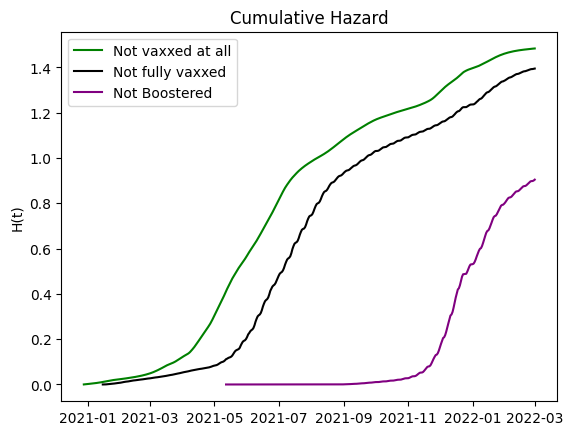

In [ ]:
plt.title("Cumulative Hazard")
plt.ylabel("H(t)")

plt.plot(ger.date, H_t, color = "green", label = "Not vaxxed at all")
plt.plot(ger.date, H_t2, color = "black", label = "Not fully vaxxed")
plt.plot(ger.date, H_t3, color = "purple", label = "Not Boostered")
plt.legend()
plt.show()

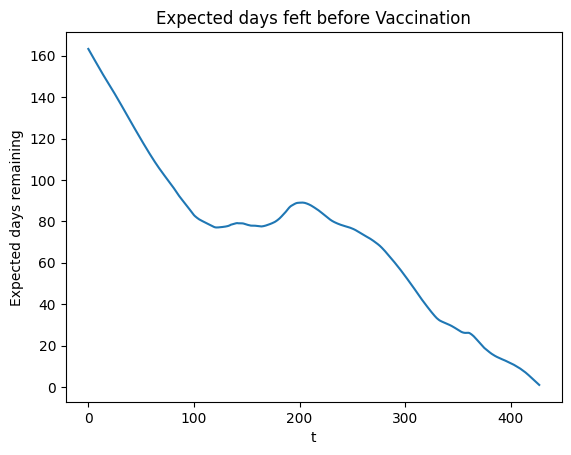

In [ ]:
def RemainingLifetime(pmf, filler=None):
    d = {}
    for t in sorted(pmf.keys())[:-1]:
        pmf[t] = 0
        pmf = normalize(pmf)
        
        mu = sum([i * j for i,j in pmf.items()])
        d[t] = mu - t
        
    return pd.Series(d)

exp_days_rem = RemainingLifetime(pmf)

plt.plot(range(len(exp_days_rem)), exp_days_rem)
plt.ylabel("Expected days remaining")
plt.xlabel("t")
plt.title("Expected days feft before Vaccination")
plt.show()

Give a Date t, how long would we expect someone, to get their first Vaccination from that time on. 

Now we want to see, what could've affected the choice for Vaccination. For that, we download Data about restrictions in Germany. 

from: https://www.psycharchives.org/index.php/en/item/8a0c3db3-d4bf-46dd-8ffc-557430d45ddd
<br>
<br>
New variables include restrictions on travel and gastronomy. The variable trvl (travel) comprises the following categories:<br> fully restricted (=2) reflecting a potential general ban to travel within Germany (except for sound reasons like health or business); partially restricted (=1): travels are allowed but may be restricted through prohibition of accommodation or entry ban for certain groups (e.g. people from risk areas); free (=0): no travel and accommodation restrictions in place). 
<br>The variable gastr (gastronomy) comprises: fully restricted (=2): closure of restaurants or bars; partially restricted (=1): Only take-away or food delivery services are allowed; free (=0): restaurants are allowed to open without restrictions). Further, the variables msk (recommendations to wear a mask) and zoo (restrictions of zoo visits) have been adjusted.

In [ ]:
restrict = pd.read_csv("Data/restrict.csv")
restrict = restrict.drop("Unnamed: 0", axis = 1)
restrict.head()

,state,Measure,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,...,2021-10-22,2021-10-23,2021-10-24,2021-10-25,2021-10-26,2021-10-27,2021-10-28,2021-10-29,2021-10-30,2021-10-31
0,Baden-Wuerttemberg,leavehome,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Baden-Wuerttemberg,dist,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Baden-Wuerttemberg,msk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,Baden-Wuerttemberg,shppng,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Baden-Wuerttemberg,hcut,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Create a *additative restriction-Score* for all of Germany, by adding all the scores (leavehome, dist, msk,etc. ...) from all the states together, to get the timeline. 

In [ ]:
score = restrict.iloc[:,2:].sum(axis = 0).reset_index()
score.columns = ["date", "restrict"]
score['date'] = pd.to_datetime(score['date'])

C:\Users\zogaj\AppData\Local\Temp\ipykernel_9532\2453312130.py:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  score = restrict.iloc[:,2:].sum(axis = 0).reset_index()


In [ ]:
ger = pd.merge(ger, score, on='date', how ='left')
#ger.restrict.fillna(0)

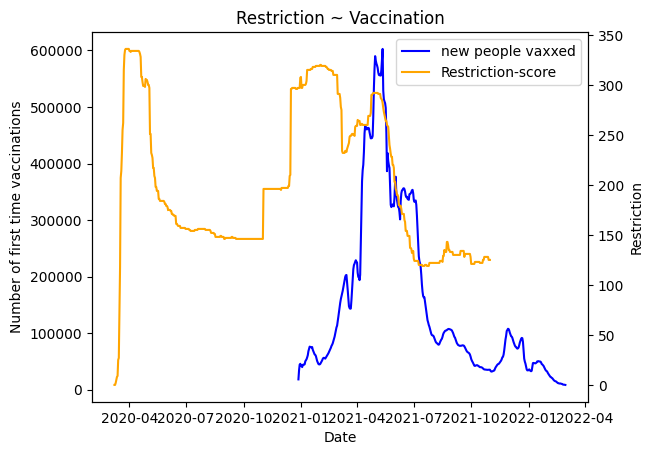

In [ ]:
fig, ax1 = plt.subplots()
lin1 = ax1.plot(ger.date, ger.new_people_vaccinated_smoothed, color = "blue", label = "new people vaxxed")

plt.ylabel("Number of first time vaccinations")
plt.xlabel("Date")
plt.title("Restriction ~ Vaccination")

ax2 = ax1.twinx() #creates the second axis 
lin2 = ax2.plot(ger.date, ger.restrict, color = "orange", label = "Restriction-score")
ax2.set_ylabel("Restriction")

lines = lin1 + lin2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels)
plt.show()

In [ ]:
ger["restrict_7"] = ger.restrict.shift(7) # Restrictionscore 7 days Prior
ger["death_7"] = ger.new_deaths_smoothed.shift(7) # Deaths 7 days Prior
ger = ger[ger.new_vaccinations > 0] #only interested at the time, where the campaign began
ger["restrict_7"] = ger["restrict_7"].fillna(0)


,date,new_vaccinations,total_vaccinations,people_fully_vaccinated,new_people_vaccinated_smoothed,total_boosters,new_deaths,total_deaths,new_deaths_smoothed,total_cases,...,new_cases_smoothed,idx,not_vaxed_at_all,not_full_vaxed,not_boostered,new_full_vaxed,new_boostered,restrict,restrict_7,death_7
307,2020-12-28,18073.0,42500.0,NaN,18073.0,NaN,531.0,46993.0,817.857,1660132.0,...,19832.000,308,83351767.0,NaN,NaN,NaN,NaN,297.0,297.0,922.857
308,2020-12-29,50229.0,92729.0,NaN,34151.0,NaN,896.0,47889.0,813.429,1675844.0,...,19179.000,309,83317616.0,NaN,NaN,NaN,NaN,297.0,297.0,936.714
309,2020-12-30,64213.0,156942.0,NaN,44172.0,NaN,1253.0,49142.0,821.143,1703389.0,...,18977.571,310,83273444.0,NaN,NaN,NaN,NaN,297.0,297.0,962.857
310,2020-12-31,49985.0,206927.0,NaN,45625.0,NaN,1299.0,50441.0,827.143,1734436.0,...,18559.429,311,83227819.0,NaN,NaN,NaN,NaN,307.0,296.0,989.571
311,2021-01-01,25723.0,232650.0,NaN,41645.0,NaN,778.0,51219.0,836.429,1753980.0,...,18335.143,312,83186174.0,NaN,NaN,NaN,NaN,308.0,296.0,924.571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,2022-02-25,176111.0,174115508.0,62646972.0,8971.0,49375410.0,264.0,128251.0,238.429,14510612.0,...,159932.571,732,18937684.0,20722868.0,33994430.0,39935.994418,142328.072396,NaN,NaN,248.143
732,2022-02-26,61980.0,174177488.0,62665386.0,8725.0,49413931.0,257.0,128508.0,238.000,14682414.0,...,158939.714,733,18928959.0,20704454.0,33955909.0,37783.794976,131947.365156,NaN,NaN,249.857
733,2022-02-27,19343.0,174196831.0,62670403.0,8721.0,49425894.0,153.0,128661.0,233.143,14791029.0,...,157368.429,734,18920238.0,20699437.0,33943946.0,34507.115478,119948.928640,NaN,NaN,252.429
734,2022-02-28,103462.0,174300293.0,62688649.0,8509.0,49502268.0,89.0,128750.0,230.286,14846562.0,...,156125.000,735,18911729.0,20681191.0,33867572.0,32881.003931,115591.435776,NaN,NaN,251.571


For Survival regression, we need to simulate when every Person has (or not) taken their Vaccine.
<br>
Duratio: n days after the Vaccine
<br>
Observed: wheter or not, on that day, the Vaccination was done. 

In [ ]:
v = np.array(pd.Series([0]).append(ger.new_people_vaccinated_smoothed, ignore_index=True), dtype = "int64")

def gen_pop(v):
    arr = np.zeros((ger_pop, 2), dtype='int32')
    
    for idx, e in enumerate(v):
    
        prev = sum(v[:idx+1])
        cur = sum(v[:idx+2])
    
        # cur = npeople
        arr[prev:cur, 0] = (idx + 1)
        arr[prev:cur, 1] = 1
    
    arr[int(sum(v)):, 0] = (len(v))
    return (pd.DataFrame(arr, columns=['duration', 'observed']))
    
dur_op =  gen_pop(v)
dur_op

C:\Users\zogaj\AppData\Local\Temp\ipykernel_9532\3685911880.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  v = np.array(pd.Series([0]).append(ger.new_people_vaccinated_smoothed, ignore_index=True), dtype = "int64")


,duration,observed
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
83369835,430,0
83369836,430,0
83369837,430,0
83369838,430,0


In [151]:
def create_x_var(x:str):
    """
    x: Variable to be created
    """
    x = ger.apply(lambda row: np.repeat(row[x], row['new_people_vaccinated_smoothed']), axis=1)

    res = []
    for i in range(len(x)):
        res.append(x.iloc[i])

    return pd.Series(np.concatenate(res))

dur_op["death_7"] = create_x_var("death_7")
dur_op["restrict_7"] = create_x_var("restrict_7")

In [152]:
dur_op[dur_op.death_7 > 0]

,duration,observed,death_7,restrict_7
0,1,1,922.857,297.0
1,1,1,922.857,297.0
2,1,1,922.857,297.0
3,1,1,922.857,297.0
4,1,1,922.857,297.0
...,...,...,...,...
64466388,429,1,252.000,0.0
64466389,429,1,252.000,0.0
64466390,429,1,252.000,0.0
64466391,429,1,252.000,0.0
